In [232]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import matplotlib.pyplot as plt


In [233]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [234]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")


In [235]:
latent_inputs = keras.Input(shape=(latent_dim))
x = layers.Dense(units=np.prod(shape_before_flattening), activation="relu")(latent_inputs)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, (3,3), activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_63 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_31 (Reshape)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_90 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_91 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_92 (Conv2D  (None, 28, 28, 1)        289 

In [236]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        trainable_vars = self.trainable_variables
        trainable_weights = self.trainable_weights

        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "Total Loss": self.total_loss_tracker.result(),
            "Reconstruction Loss": self.reconstruction_loss_tracker.result(),
            "KL-Loss": self.kl_loss_tracker.result(),
        }

In [237]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [238]:
from keras.callbacks import History
history = History()

In [243]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=32, callbacks=[history])

Epoch 1/10


2023-01-07 18:04:31.618310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 28s 14ms/step - Total Loss: 159.5843 - Reconstruction Loss: 154.6581 - KL-Loss: 4.9263
Epoch 2/10
1875/1875 [==============================] - 27s 14ms/step - Total Loss: 157.1659 - Reconstruction Loss: 152.1107 - KL-Loss: 5.0552
Epoch 3/10
1875/1875 [==============================] - 25s 14ms/step - Total Loss: 155.9491 - Reconstruction Loss: 150.7612 - KL-Loss: 5.1880
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - Total Loss: 155.1597 - Reconstruction Loss: 149.9396 - KL-Loss: 5.2201
Epoch 5/10
1875/1875 [==============================] - 27s 14ms/step - Total Loss: 154.1462 - Reconstruction Loss: 148.8456 - KL-Loss: 5.3006
Epoch 6/10
1875/1875 [==============================] - 27s 14ms/step - Total Loss: 153.8089 - Reconstruction Loss: 148.4512 - KL-Loss: 5.3577
Epoch 7/10
1875/1875 [==============================] - 27s 14ms/step - Total Loss: 153.1977 - Reconstruction Loss: 147.8153 - KL-Loss: 5.3823
Epoch 8/10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


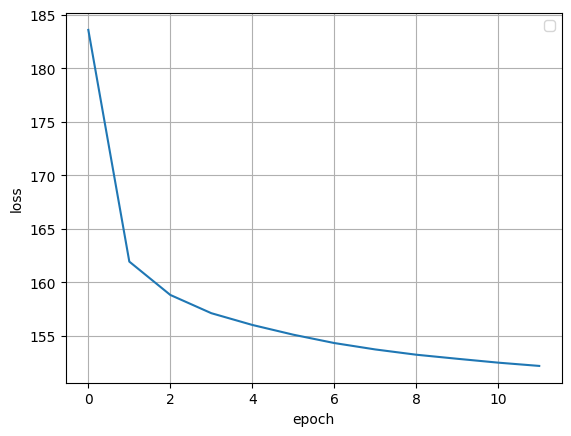

In [244]:
plt.plot(history.history["Total Loss"])
plt.grid("on")
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap="viridis")
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(vae, x_train, y_train)

In [ ]:
mean, var, latent_vars = encoder.predict(x_test)

decoded_data = decoder.predict(latent_vars)

# Plotting the results
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()